In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [43]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from  sklearn.preprocessing import label_binarize
import shap
import conifer
import datetime
from sklearn.datasets import make_hastie_10_2
import logging
import sys

In [3]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"
plots_dir = "plots"

In [4]:
# File paths for signal and background root files: 
photon_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered.h5"
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/shower_shape_studies/gen_filtered_neutrino.h5"

In [5]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

In [6]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    """Filter DataFrame to keep only the highest-energy match per event within the delta R threshold."""
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi', 'cl3d_energy', 'event']

    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    df = df.copy()  # Avoid modifying original DataFrame
    # Filter to keep only clusters with cl3d_energy > 0
    df = df[df['cl3d_ienergy'] > 0]
    # Compute delta_r
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    # Filter based on delta_r threshold
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    # Sort by event_id, cl3d_energy (descending), delta_r (ascending)
    df_sorted = df_filtered.sort_values(by=['event', 'cl3d_energy', 'delta_r'], ascending=[True, False, True])
    # Keep only the first occurrence per event_id
    df_best_match = df_sorted.groupby('event').first().reset_index()
    return df_best_match

In [7]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [8]:
def plot_histograms(df_photon_pu200, df_neutrino_pu200, variables, num_bins=40, int_num_bins=10, cl3d_pt_range=(20, 30), figsize=(8, 4)):
    df_photon_pu200_filtered = df_photon_pu200[(df_photon_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_photon_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    df_neutrino_pu200_filtered = df_neutrino_pu200[(df_neutrino_pu200['cl3d_pt'] >= cl3d_pt_range[0]) & (df_neutrino_pu200['cl3d_pt'] <= cl3d_pt_range[1])]
    for var in variables:
        plt.figure(figsize=figsize)
        if df_photon_pu200_filtered[var].dtype in ['int64', 'int32']:
            min_value = min(
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, 1)
        else:
            min_value = min(
                df_photon_pu200_filtered[var].min(),
                df_neutrino_pu200_filtered[var].min()
            )
            max_value = max(
                df_photon_pu200_filtered[var].max(),
                df_neutrino_pu200_filtered[var].max()
            )
            bin_width = (max_value - min_value) / num_bins
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)
        plt.hist(df_photon_pu200_filtered[var], bins=bin_edges, color='b', histtype='step', linewidth=1.5, label='Photon (200 PU)', density = True)
        plt.hist(df_neutrino_pu200_filtered[var], bins=bin_edges, color='r', histtype='step', linewidth=1.5, label='Neutrino (200 PU)', density = True)
        plt.title(f"{var} Histogram (cl3d_pt between {cl3d_pt_range[0]} and {cl3d_pt_range[1]} GeV)")
        plt.xlabel(var)
        plt.ylabel('Normalized Frequency')
        plt.legend()
        plt.tight_layout()
        filename = os.path.join(plots_dir,f"{var}_histogram_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png")
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        plt.show()
        plt.close()

In [9]:
def calculate_partial_auc(y_true, y_pred_probs, tpr_min, tpr_max):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    valid_idx = (tpr >= tpr_min) & (tpr <= tpr_max)
    partial_auc = auc(fpr[valid_idx], tpr[valid_idx])
    return partial_auc

def plot_roc_curve(y_true, y_pred_probs, threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
    valid_idx = tpr > threshold
    plt.fill_between(fpr[valid_idx], tpr[valid_idx], color='orange', alpha=0.3, label=f'Signal efficiency > {threshold}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    filename = os.path.join(plots_dir,f"roc_curve.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()
    plt.close()

In [10]:
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)

In [11]:
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)
neutrinoPU200_df_20GeV = neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

In [12]:
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [13]:
# Get the common columns between signal and background DataFrames
common_columns = photonPU200_df_filtered.columns.intersection(neutrinoPU200_df_20GeV.columns)

# Keep only the common columns in both DataFrames
neutrinoPU200_df_final = neutrinoPU200_df_20GeV[common_columns]
photonPU200_df_final = photonPU200_df_filtered[common_columns]

In [14]:
# Assign class labels
neutrinoPU200_df_final['label'] = 0  # Neutrino background
photonPU200_df_final['label'] = 1    # Photon signal with PU=200

# Combine datasets
df_combined = pd.concat([neutrinoPU200_df_final, photonPU200_df_final], ignore_index=True)

/tmp/ipykernel_270204/900917616.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  photonPU200_df_final['label'] = 1    # Photon signal with PU=200


In [15]:
columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

In [16]:
#filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]
filtered_data = df_combined[columns_for_training + ['label']].copy()
feature_importance_by_bin = {}
shap_values_by_bin = {}
mean_shap_values = {}

In [17]:
def maxbits(feat, maxbit=8, minbit=2):
    """Determine bit allocation for quantization."""
    if feat.dtype == 'float64':
        return maxbit  # Use max bit if it's a continuous feature (float)
    elif feat.dtype == 'int64':
        unique_vals = np.unique(feat)
        nval = len(unique_vals)
        if nval == 1:  # Edge case: If there's only one unique value, assign minimum bit
            return 1
        for i in range(minbit, maxbit + 1):  # Start from minbit to maxbit
            if 2 ** i >= nval:
                return i
        return maxbit  # Default to maxbit if no match found
    return minbit  # Fallback case

In [18]:
def quantize(feat, nbits, method, fmin, fmax):
    """Apply quantization to features."""
    nbins = 2 ** nbits
    bins = np.linspace(fmin, fmax, nbins + 1) if method == 'uniform' else np.percentile(feat, np.linspace(0, 100, nbins + 1))
    return np.digitize(feat, bins, right=True)

In [19]:
nbits_dict = {col: maxbits(filtered_data[col]) for col in columns_for_training}
fmin_dict, fmax_dict = filtered_data[columns_for_training].min(), filtered_data[columns_for_training].max()

In [20]:
for col, nbits in nbits_dict.items():
    if nbits is None or not isinstance(nbits, int):
        print(f"Warning: Feature '{col}' has an invalid bit allocation: {nbits}")
        nbits_dict[col] = 6  # Assign a default value (e.g., 6 bits)
# --------------------- Train XGBoost Model ---------------------
X = filtered_data[columns_for_training]
y = filtered_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 100,
    "max_depth": 4,
    "learning_rate": 0.005,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "gamma": 4.9,
    "reg_lambda": 1,
    "reg_alpha": 0.7,
    "n_jobs": 20
}

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=4.9, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=20, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Saved: plots/roc_curve.png


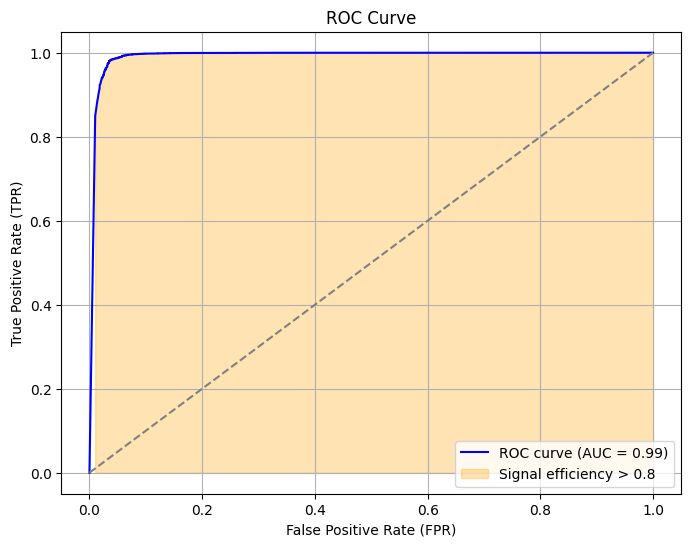

Partial AUC between TPR = 0.8 and TPR = 1: 0.9874


In [22]:
# --------------------- Evaluate Model ---------------------
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_probs, 0.8)

partial_auc = calculate_partial_auc(y_test, y_pred_probs, 0.8, 1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1: {partial_auc:.4f}")

In [23]:
y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification
partial_auc = calculate_partial_auc(y_test, y_pred_probs, tpr_min=0.8, tpr_max=1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1: {partial_auc:.4f}")

Partial AUC between TPR = 0.8 and TPR = 1: 0.9874


Saved: plots/roc_curve.png


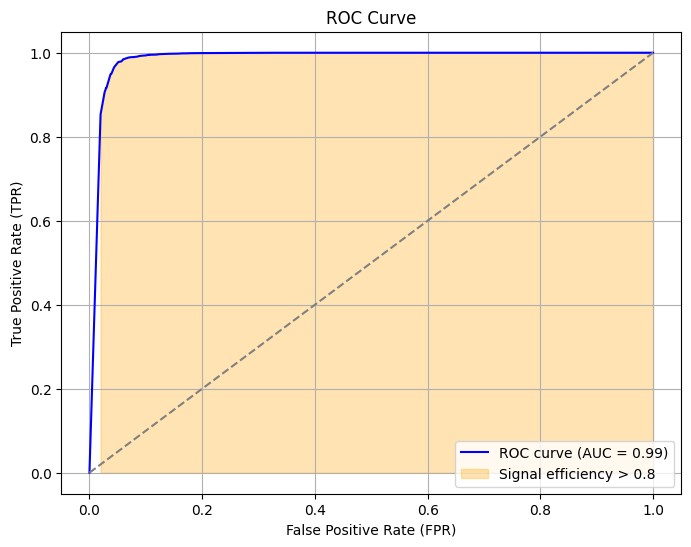

Partial AUC between TPR = 0.8 and TPR = 1 (quantized): 0.9773


In [24]:
# Quantize Features
quantized_data = filtered_data.copy()

# Apply quantization to each feature
for col in columns_for_training:
    nbits = nbits_dict[col]
    fmin = filtered_data[col].min()
    fmax = filtered_data[col].max()
    
    # Apply the quantization method (e.g., uniform binning)
    quantized_data[col] = quantize(filtered_data[col], nbits, method='uniform', fmin=fmin, fmax=fmax)

# --------------------- Train XGBoost Model with Quantized Data ---------------------
X_quantized = quantized_data[columns_for_training]
y = filtered_data['label']  # Target variable stays the same

X_train, X_test, y_train, y_test = train_test_split(X_quantized, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)

# --------------------- Evaluate Model ---------------------
y_pred_probs_quantized = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_probs_quantized, 0.8)

partial_auc_quantized = calculate_partial_auc(y_test, y_pred_probs_quantized, 0.8, 1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1 (quantized): {partial_auc_quantized:.4f}")

In [25]:
print(nbits_dict)

{'cl3d_showerlength': 2, 'cl3d_coreshowerlength': 2, 'cl3d_firstlayer': 2, 'cl3d_maxlayer': 2, 'cl3d_seetot': 2, 'cl3d_seemax': 2, 'cl3d_spptot': 2, 'cl3d_sppmax': 2, 'cl3d_szz': 2, 'cl3d_srrtot': 2, 'cl3d_srrmax': 2, 'cl3d_srrmean': 2, 'cl3d_varrr': 2, 'cl3d_varzz': 2, 'cl3d_varee': 2, 'cl3d_varpp': 2, 'cl3d_emaxe': 2, 'cl3d_meanz': 2, 'cl3d_layer10': 2, 'cl3d_layer50': 2, 'cl3d_layer90': 2, 'cl3d_first1layers': 2, 'cl3d_first3layers': 2, 'cl3d_first5layers': 2, 'cl3d_last1layers': 2, 'cl3d_last3layers': 2, 'cl3d_last5layers': 2, 'cl3d_emax1layers': 2, 'cl3d_emax3layers': 2}


In [26]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

 99%|===================| 22559/22898 [00:23<00:00]        

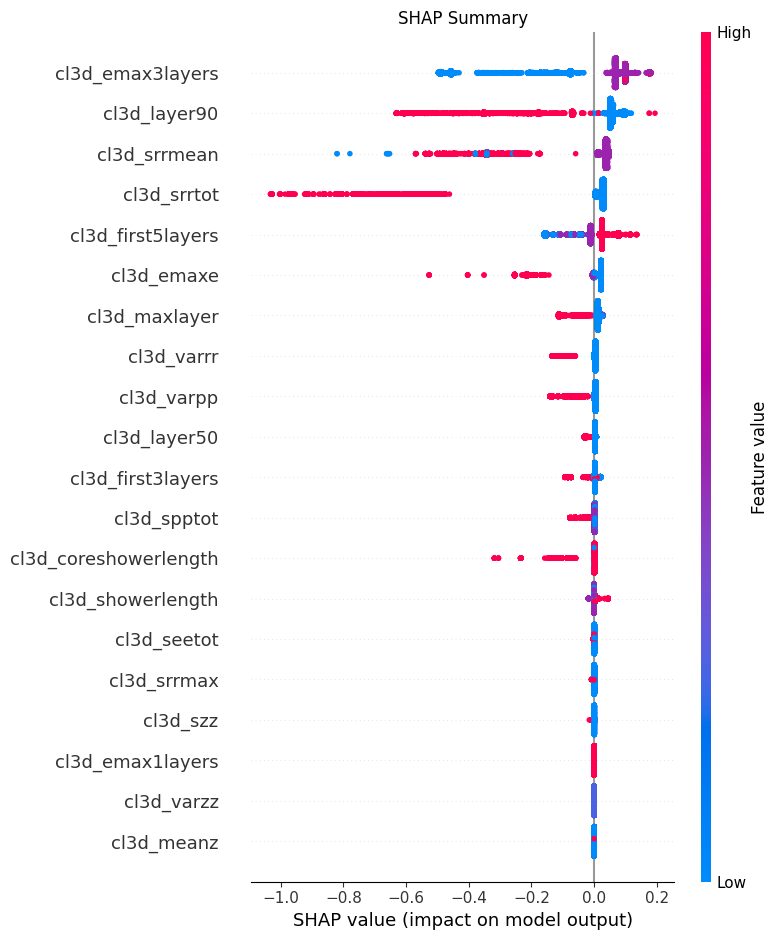

Saved: shap_summary.png


<Figure size 640x480 with 0 Axes>

In [27]:
# Generate SHAP summary plot
plt.figure()
plt.title(f"SHAP Summary")
shap.summary_plot(shap_values, X_test)
filename = f"shap_summary.png"
plt.savefig(filename, dpi=300)
print(f"Saved: {filename}")
plt.show()

In [44]:
# Create a conifer config for hardware synthesis
cfg = conifer.backends.vhdl.auto_config()  # Use VHDL for synthesis (can change to 'hls' if desired)

In [45]:
# Set the output directory for the synthesis process
os.makedirs('hdlprojects', exist_ok=True)
path = f'hdlprojects/prj_vhdl_{str(datetime.date.today())}_{time.time()}'
if os.path.exists(path):
    remove_folder(path)  # Clean up old project if exists
cfg['OutputDir'] = path
cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'  # Xilinx FPGA part (can be changed)
cfg['Precision'] = f'ap_fixed<{max(nbits_dict.values())},{0}>'  # Use maximum precision across all features
cfg['ProjectName'] = 'hgcal_vhdl'
cfg['ClockPeriod'] = 3  # Set clock period (change if necessary)

In [42]:
bst = xgb.train(best_params, dtrain, num_round)

# Create a conifer config
cfg = conifer.backends.xilinxhls.auto_config()

converter = conifer.converters.convert_from_xgboost(bst, cfg)  # Create the converter object

# Convert the model into a hardware-compatible representation
cnf_model = converter.convert()

# Perform synthesis (hardware simulation)
cnf_model.build(csim=True)

# Read the synthesis report to extract the number of LUTs used
report_path = os.path.join(cfg['OutputDir'], 'util.rpt')
with open(report_path, 'r') as report:
    lines = report.readlines()

# Extract LUT count from the report (line 37 usually contains the LUT information)
LUT = int(lines[37].split('|')[2].strip())
print(f"Synthesis completed. LUTs used: {LUT}")

# --------------------- Save the Model and Data ---------------------
quantized_data.to_csv(f'{path}/quantized_data.csv', index=False)  # Save quantized data
best_model.save_model(f'{path}/model.model')  # Save the trained model

NameError: name 'dtrain' is not defined

In [ ]:
# other parts such as ROC data or SHAP plots here.

In [36]:
print(dir(conifer.converters.xgboost))

['Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__xgb_version', 'convert', 'json', 'logger', 'logging', 'pandas', 'splitting_conventions', 'treeToDict', 'version', 'xgb']
